In [2]:
!pip install -q torch==1.0.0 torchvision

tcmalloc: large alloc 1073750016 bytes == 0x618fe000 @  0x7fc8464b92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [5]:
torch.cuda.is_available()

True

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [9]:
num_worker = 0

batch_size = 64

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data',train=True,transform=transform,download=True)
test_data = datasets.MNIST(root='data',train=False,transform=transform,download=True)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_worker)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_worker)




Processing...
Done!


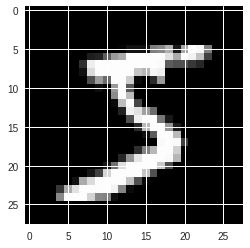

In [15]:
data_iter = iter(train_loader)
imgs,label = data_iter.next()
imgs = imgs.numpy()

img = imgs[0].squeeze()

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class NeuralNet(nn.Module):
  
  def __init__(self,use_batch_norm,input_size=784,hidden_dim=256,output_size=10):
    super(NeuralNet,self).__init__()
    
    self.input_size = input_size
    self.hidden_dim = hidden_dim
    self.output_size = output_size
    self.use_batch_norm = use_batch_norm
    
    if use_batch_norm:
      self.fc1 = nn.Linear(input_size,hidden_dim*2,bias=False)
      self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
      self.fc2 = nn.Linear(hidden_dim*2,hidden_dim*4,bias=False)
      self.batch_norm2 = nn.BatchNorm1d(hidden_dim*4)
      
      
    else:
      self.fc1 = nn.Linear(input_size,hidden_dim*2)
      self.fc2 = nn.Linear(hidden_dim*2,hidden_dim*4)
      
    self.fc3 = nn.Linear(hidden_dim*4,output_size)
    
  def forward(self,x):
    
    x = x.view(-1,28*28)
    if self.use_batch_norm:
      x = self.fc1(x)
      x = self.batch_norm1(x)
      x = self.fc2(x)
      x = self.batch_norm2(x)
    else:
      x = self.fc1(x)
      x = self.fc2(x)
    x = self.fc3(x)
   
  
    return x
    
    
  

In [28]:
net_batchnorm = NeuralNet(use_batch_norm=True)
net_no_batchnorm = NeuralNet(use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_batchnorm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=False)
  (batch_norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


In [0]:
from torch import optim

In [0]:
def train(model,n_epochs=10):
  
  losses=[]
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.01)
  
  model.train()
  
  for epoch in range(1,n_epochs+1):
    train_loss = 0.0

    batch_count=0
    
    for batch_idx,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      logits = model(data)
      
      loss = criterion(logits,target)
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item()
      batch_count+=1
      
      
    epoch_train_loss = train_loss/batch_count
    losses.append(epoch_train_loss)
    print('Epoch {} :\tTraining loss:{:.6f} '.format(epoch,epoch_train_loss))
    
  return losses
      
  

In [33]:
losses_batch_norm = train(net_batchnorm)

Epoch 1 :	Training loss:0.321301 
Epoch 2 :	Training loss:0.305478 
Epoch 3 :	Training loss:0.295451 
Epoch 4 :	Training loss:0.287831 
Epoch 5 :	Training loss:0.281529 
Epoch 6 :	Training loss:0.276055 
Epoch 7 :	Training loss:0.271148 
Epoch 8 :	Training loss:0.266658 
Epoch 9 :	Training loss:0.262488 
Epoch 10 :	Training loss:0.258572 


In [35]:
losses_batch_NO_norm = train(net_no_batchnorm)

Epoch 1 :	Training loss:0.983982 
Epoch 2 :	Training loss:0.410457 
Epoch 3 :	Training loss:0.352239 
Epoch 4 :	Training loss:0.328378 
Epoch 5 :	Training loss:0.314525 
Epoch 6 :	Training loss:0.305221 
Epoch 7 :	Training loss:0.298397 
Epoch 8 :	Training loss:0.293088 
Epoch 9 :	Training loss:0.288786 
Epoch 10 :	Training loss:0.285197 


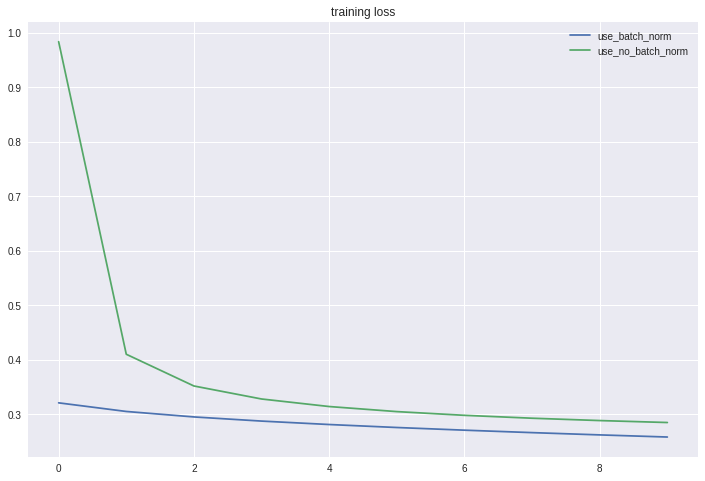

In [37]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(losses_batch_norm,label='use_batch_norm')
plt.plot(losses_batch_NO_norm,label='use_no_batch_norm')
plt.title('training loss')
plt.legend()
plt.show()

In [0]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item()*batch_size
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [56]:
test(net_batchnorm, train=True)

Test Loss: 0.285113

Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1: 98% (1117/1135)
Test Accuracy of     2: 87% (903/1032)
Test Accuracy of     3: 90% (918/1010)
Test Accuracy of     4: 91% (899/982)
Test Accuracy of     5: 87% (782/892)
Test Accuracy of     6: 93% (894/958)
Test Accuracy of     7: 90% (934/1028)
Test Accuracy of     8: 87% (850/974)
Test Accuracy of     9: 91% (922/1009)

Test Accuracy (Overall): 91% (9179/10000)


In [43]:
test(net_batchnorm, train=False)

Test Loss: 0.300810

Test Accuracy of     0: 97% (956/980)
Test Accuracy of     1: 97% (1108/1135)
Test Accuracy of     2: 86% (888/1032)
Test Accuracy of     3: 92% (931/1010)
Test Accuracy of     4: 90% (886/982)
Test Accuracy of     5: 85% (762/892)
Test Accuracy of     6: 94% (910/958)
Test Accuracy of     7: 90% (929/1028)
Test Accuracy of     8: 84% (821/974)
Test Accuracy of     9: 92% (936/1009)

Test Accuracy (Overall): 91% (9127/10000)


In [44]:
test(net_no_batchnorm, train=False)

Test Loss: 0.281208

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 97% (1108/1135)
Test Accuracy of     2: 88% (910/1032)
Test Accuracy of     3: 89% (908/1010)
Test Accuracy of     4: 91% (898/982)
Test Accuracy of     5: 88% (791/892)
Test Accuracy of     6: 94% (902/958)
Test Accuracy of     7: 91% (937/1028)
Test Accuracy of     8: 87% (854/974)
Test Accuracy of     9: 91% (925/1009)

Test Accuracy (Overall): 91% (9197/10000)
